# Lab: Phân lớp

- MSSV: 22120336
- Họ và tên: Võ Tuấn Thành

## Yêu cầu bài tập

**Cách làm bài**


Bạn sẽ làm trực tiếp trên file notebook này; trong file, từ `TODO` để cho biết những phần mà bạn cần phải làm.

Bạn có thể thảo luận ý tưởng cũng như tham khảo các tài liệu, nhưng *code và bài làm phải là của bạn*. 

Nếu vi phạm thì sẽ bị 0 điểm cho bài tập này.

**Cách nộp bài**

Trước khi nộp bài, rerun lại notebook (`Kernel` -> `Restart & Run All`).

Sau đó, đặt tên notebook bằng `MSSV` của bạn (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên notebook là `1234567.ipynb`) và nộp ở link trên moodle.

**Nội dung bài tập**

Trong bài này, bạn sẽ cài đặt 2 thuật toán phân lớp: 
1. Cây quyết định (Decision tree)
2. Gaussian Naive Bayes

**Một số lưu ý**
1. Chỉ cần phát hiện có dấu hiện có sau chép code sẽ 0 điểm cả lab và có thể dẫn đến không điểm môn học
2. Sai format nộp bài sẽ bị trừ 20% số điểm
3. Trễ deadline 1 ngày sẽ bị trừ 40% số điểm. Sau 24h kể từ hạn nộp sẽ không nhận bất kì bài nộp bổ sung nào.
4. Các thắc mắc về bài tập, các bạn vui lòng liên hệ giáo viên qua email `ntthuhang0131@gmail.com` với tiêu đề `[Cơ sở trí tuệ nhân tạo - CQ2022/22 - Thắc mắc lab 03]`

### Thêm thư viện cần thiết

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

### Load dữ liệu Iris

In [2]:
from sklearn.model_selection import train_test_split
iris=datasets.load_iris()

X=iris.data
y=iris.target

#split dataset into training data and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=42)

## 1. Cây quyết định (Decision Tree)

## 1.1 Iterative Dichotomiser 3 (ID3) (2 đ)

### 1.1.1 Information Gain

Thông tin kỳ vọng (entropy):

$$Entropy=-\sum_{i}^{n}p_ilog_{2}(p_i)$$

Hàm entropy đạt giá trị nhỏ nhất nếu có một giá trị $p_i=1$, đạt giá trị lớn nhất nếu tất cả các $p_i$ bằng nhau. Những tính chất này của hàm entropy khiến nó được sử dụng trong việc đo độ hỗn loạn của một phép phân chia của ID3.

In [3]:
def entropy(counts, n_samples):
    """
    Parameters:
    -----------
    counts: shape (n_classes): list number of samples in each class
    n_samples: number of data samples
    
    -----------
    return entropy 
    """
    #TODO
    entropy = 0

    for count in counts:
        if count != 0:
            entropy += -count/n_samples * np.log2(count/n_samples)
    
    return entropy

In [4]:
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    n_samples = len(division)
    n_classes = set(division)
    
    counts=[]
    #count samples in each class then store it to list counts
    #TODO:
    for i in n_classes:
        counts.append(np.sum(division == i))
    
    return entropy(counts,n_samples),n_samples


def get_entropy(y_predict, y):
    """
    Returns entropy of a split
    y_predict is the split decision by cutoff, True/Fasle
    """
    n = len(y)
    s_true, n_true = entropy_of_one_division(y[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y[~y_predict]) # right hand side entropy
    s = n_true/n * s_true + n_false/n * s_false # overall entropy
    return s

Độ lợi thông tin phân lớp tập D theo thuộc tính A:
$$ Gain(A)=Entrophy(D)-Entrophy_{A}(D)$$

Trong ID3, tại mỗi node, thuộc tính được chọn được xác định dựa trên là thuộc tính khiến cho information gain đạt giá trị lớn nhất.

Các thuộc tính của tập Iris đều có giá trị liên tục. Do đó ta cần rời rạc hóa cho từng thuộc tính. Cách đơn giản là sử dụng một ngưỡng `cutoff` chia giá trị của dữ liệu trên mỗi thuộc tính sẽ làm 2 phần: `value<cutoff` và `value>=cutoff`.

Để tìm ngưỡng `cutoff` tốt nhất cho mỗi thuộc tính ta lần lượt thay `cutoff` bằng các giá trị của thuộc tính sau đó tính entropy, `cutoff` tốt nhất khi entropy bé nhất.  

### 1.1.2 Decision tree

In [5]:
class DecisionTreeClassifier:
    def __init__(self, tree=None, depth=0):
        '''Parameters:
        -----------------
        tree: decision tree
        depth: depth of decision tree after training'''
        
        self.depth = depth
        self.tree=tree
    def fit(self, X, y, node={}, depth=0):
        '''Parameter:
        -----------------
        X: training data
        y: label of training data
        ------------------
        return: node 
        
        node: each node represented by cutoff value and column index, value and children.
         - cutoff value is thresold where you divide your attribute
         - column index is your data attribute index
         - value of node is mean value of label indexes, 
           if a node is leaf all data samples will have same label
        
        Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.
        '''
        
        #Stop conditions
        
        #if all value of y are the same 
        if np.all(y==y[0]):
            return {'val':y[0]}

        else: 
            col_idx, cutoff, entropy = self.find_best_split_of_all(X, y)    # find one split given an information gain 
            y_left = y[X[:, col_idx] < cutoff]
            y_right = y[X[:, col_idx] >= cutoff]
            node = {'index_col':col_idx,
                        'cutoff':cutoff,
                   'val':np.mean(y)}
            node['left'] = self.fit(X[X[:, col_idx] < cutoff], y_left, {}, depth+1)
            node['right'] = self.fit(X[X[:, col_idx] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.tree = node
            return node
    
    def find_best_split_of_all(self, X, y):
        col_idx = None
        min_entropy = 1
        cutoff = None
        for i, col_data in enumerate(X.T):
            entropy, cur_cutoff = self.find_best_split(col_data, y)
            if entropy == 0:                   #best entropy
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col_idx = i
                cutoff = cur_cutoff
               
        return col_idx, cutoff, min_entropy
    
    def find_best_split(self, col_data, y):
        ''' Parameters:
        -------------
        col_data: data samples in column'''
         
        min_entropy = 10
        cutoff = None

        #Loop through col_data find cutoff where entropy is minimum
        #TODO
        for value in np.unique(col_data):
            y_predict = col_data < value
            entropy = get_entropy(y_predict, y)
            
            if entropy == 0:  # best entropy
                return entropy, value
            elif entropy <= min_entropy:
                min_entropy = entropy
                cutoff = value
    
        return min_entropy, cutoff
                                               
    def predict(self, X):
        tree = self.tree
        pred = np.zeros(shape=len(X))
        for i, c in enumerate(X):
            pred[i] = self._predict(c)
        return pred
    
    def _predict(self, row):
        cur_layer = self.tree
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

### 1.1.3 Classification on Iris Dataset

In [6]:
model = DecisionTreeClassifier()
tree = model.fit(X_train, y_train)
pred=model.predict(X_train)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train,pred))
pred=model.predict(X_test)
print('Accuracy of your decision tree model:', accuracy_score(y_test,pred))

Accuracy of your decision tree model on training data: 1.0
Accuracy of your decision tree model: 0.96


## 1.2 CART (Classification and Regression Trees) (2 đ)

Các bạn tự cài đặt lại thuật toán CART và test trên tập dữ liệu Iris (tham khảo cách trình bày ở `phần 1.1`)

### Gini Index

- Công thức:
$$Gini(D)=1-\sum_{i=1}^{n}p_i^2$$
- Gini index càng nhỏ thì độ tinh khiết của tập dữ liệu càng cao.

In [7]:
def gini_index(counts, n_samples):
    res = 1
    for count in counts:
        if count == 0: continue
        pi = count / n_samples
        res -= pi ** 2
    
    return res

### 1.2.2 Decision Tree

In [8]:
class Node:
    """Tree node for CART decision tree"""
    def __init__(self, predicted_class=None, threshold=None, feature_index=None, 
                 left=None, right=None, gini=None, n_samples=None):
        self.predicted_class = predicted_class
        self.threshold = threshold
        self.feature_index = feature_index
        self.left = left
        self.right = right
        self.gini = gini
        self.n_samples = n_samples

class DecisionTreeClassifierWithGini:
    """CART Decision Tree Classifier using Gini impurity"""
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.n_classes = None
    
    def _best_split(self, X, y):
        """Find the best split for a node"""
        best_gini = float('inf')
        best_threshold = None
        best_feature = None
        n_samples = len(y)
        
        # If pure node, return immediately
        if len(np.unique(y)) == 1:
            return None, None, gini_index(np.bincount(y, minlength=self.n_classes), n_samples)
            
        # Try each feature
        for feature_idx in range(X.shape[1]):
            # Get unique values for threshold testing
            thresholds = np.unique(X[:, feature_idx])
            
            # Try each threshold
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                
                # Skip if split would result in empty node
                if not 0 < left_mask.sum() < n_samples:
                    continue
                    
                # Calculate gini impurity for split
                left_counts = np.bincount(y[left_mask], minlength=self.n_classes)
                right_counts = np.bincount(y[~left_mask], minlength=self.n_classes)
                
                left_gini = gini_index(left_counts, left_mask.sum())
                right_gini = gini_index(right_counts, (~left_mask).sum())
                
                # Weighted average of gini values
                gini = (left_mask.sum() * left_gini + (~left_mask).sum() * right_gini) / n_samples
                
                # Update best split if this split is better
                if gini < best_gini:
                    best_gini = gini
                    best_threshold = threshold
                    best_feature = feature_idx
                    
        return best_feature, best_threshold, best_gini
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        n_samples = len(y)
        
        # Count samples per class
        classes, counts = np.unique(y, return_counts=True)
        
        # Check stopping criteria
        if ((self.max_depth is not None and depth >= self.max_depth) or 
            n_samples < self.min_samples_split or 
            len(classes) == 1):
            return Node(
                predicted_class=classes[np.argmax(counts)],
                gini=gini_index(np.bincount(y, minlength=self.n_classes), n_samples),
                n_samples=n_samples
            )
        
        # Find best split
        feature_idx, threshold, gini = self._best_split(X, y)
        
        # If no valid split found, make leaf node
        if feature_idx is None:
            return Node(
                predicted_class=classes[np.argmax(counts)],
                gini=gini,
                n_samples=n_samples
            )
        
        # Split data
        left_mask = X[:, feature_idx] <= threshold
        
        # Create decision node
        node = Node(
            feature_index=feature_idx,
            threshold=threshold,
            gini=gini,
            n_samples=n_samples
        )
        
        # Recursively build children
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[~left_mask], y[~left_mask], depth + 1)
        
        return node
    
    def fit(self, X, y):
        """Fit decision tree to training data"""
        self.n_classes = len(np.unique(y))
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_single(self, x, node):
        """Predict class for a single sample"""
        if node.predicted_class is not None:
            return node.predicted_class
            
        if x[node.feature_index] <= node.threshold:
            return self._predict_single(x, node.left)
        return self._predict_single(x, node.right)
    
    def predict(self, X):
        """Predict classes for multiple samples"""
        return np.array([self._predict_single(x, self.root) for x in X])

### 1.2.3 Classification on Iris Dataset


In [9]:
model = DecisionTreeClassifierWithGini(max_depth=3)
tree = model.fit(X_train, y_train)

pred_train = model.predict(X_train)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train, pred_train))

pred_test = model.predict(X_test)
print('Accuracy of your decision tree model on test data:', accuracy_score(y_test, pred_test))

Accuracy of your decision tree model on training data: 0.97
Accuracy of your decision tree model on test data: 0.98


## 1.3 Câu hỏi lý thuyết (2 đ)

*Đây là câu hỏi về lý thuyết có thể giúp các bạn buổi sung kiến thức cho các buổi phỏng vấn. Các bạn có thể tham khảo bất kì nguồn nào trừ ChatGPT và có thể thêm hình ảnh minh họa để có câu trả lời rõ ràng và dễ hiểu nhất. Và khi đã tham khảo phải liệt kê tài liệu tham khảo? Trường hợp phát hiện đạo văn bài làm sẽ nhận 0 điểm ngay lập tức.*

##### 1. So sánh Entropy, Gini Impurity và Variance Reduction trong Decision Tree. Khi nào nên sử dụng mỗi tiêu chí?

Câu trả lời:

Trong Decision Tree, Entropy, Gini Impurity và Variance Reduction là các tiêu chí được sử dụng để đánh giá độ "tinh khiết" của một tập dữ liệu (node) và chọn thuộc tính tốt nhất để phân chia dữ liệu tại mỗi node. Mục tiêu là giảm độ "bất ổn" (impurity) hoặc "không chắc chắn" (uncertainty) trong các node con sau khi phân chia.

*   **Entropy và Gini Impurity:** Dùng cho bài toán phân loại (classification). Entropy thường được ưu tiên khi muốn tính toán độ "bất ổn" chính xác, Gini Impurity khi ưu tiên hiệu suất tính toán.
*   **Variance Reduction:** Dùng cho bài toán hồi quy (regression).

##### 2. Overfitting trong Decision Tree là gì? Bạn có thể làm gì để giảm thiểu vấn đề này?
Câu trả lời:
 -   Overfitting xảy ra khi Decision Tree được huấn luyện quá kỹ trên dữ liệu huấn luyện, dẫn đến việc nó ghi nhớ các chi tiết nhiễu (noise) hoặc các trường hợp ngoại lệ trong dữ liệu huấn luyện thay vì học được các quy luật tổng quát.
 -   Hậu quả là cây quyết định hoạt động rất tốt trên dữ liệu huấn luyện, nhưng lại hoạt động kém khi được áp dụng lên dữ liệu mới, chưa từng thấy (dữ liệu kiểm tra).
 -   Biểu hiện của overfitting trong Decision Tree thường là một cây rất sâu, có nhiều node lá, và có nhiều nhánh chỉ xử lý các trường hợp đặc biệt trong dữ liệu huấn luyện.

##### 3. Decision Tree có phù hợp cho dữ liệu nhiều chiều hoặc dữ liệu không cân bằng không? Tại sao? 
Câu trả lời:

Descision Tree không lý tưởng cho dữ liệu nhiều chiều hoặc dữ liệu không cân bằng. Vì:
*   **Dữ liệu nhiều chiều (High-dimensional data):**
    *   **Không lý tưởng:** Decision Tree có thể gặp khó khăn do "Curse of dimensionality", dẫn đến overfitting và tốn nhiều tài nguyên. Cây có thể trở nên quá phức tạp, ghi nhớ chi tiết nhiễu thay vì học quy luật chung.
    *   **Lý do:** Số lượng thuộc tính lớn làm tăng số nhánh và node, khiến việc chọn thuộc tính phân chia tốt trở nên khó khăn.
    *   **Cần:** Các biện pháp giảm chiều dữ liệu, kỹ thuật điều chuẩn hoặc sử dụng các mô hình ensemble (như Random Forest).
*   **Dữ liệu không cân bằng (Imbalanced data):**
    *   **Không lý tưởng:** Decision Tree có xu hướng nghiêng về lớp đa số, bỏ qua các lớp thiểu số quan trọng.
    *   **Lý do:** Cây được tối ưu để giảm lỗi tổng thể, và dễ dàng đạt được điều đó bằng cách dự đoán đúng cho lớp đa số.
    *   **Cần:** Các kỹ thuật như trọng số mẫu, upsampling, downsampling, SMOTE, cost-sensitive learning hoặc sử dụng các mô hình ensemble.

##### 4. Nếu bạn có một Decision Tree quá lớn (deep tree), bạn sẽ làm gì để cải thiện khả năng tổng quát của nó?
Câu trả lời:

Khi một Decision Tree quá lớn (deep tree), nó thường bị overfitting, tức là hoạt động rất tốt trên dữ liệu huấn luyện nhưng kém trên dữ liệu mới. Để cải thiện khả năng tổng quát của nó, có thể thực hiện các biện pháp sau, tương tự như đã đề cập trong câu 2:

1.  **Giới hạn chiều sâu của cây (Maximum Depth):**
    *   Sử dụng tham số `max_depth` để giới hạn số lượng level tối đa của cây. Điều này ngăn cây không đi quá sâu và bắt đầu ghi nhớ dữ liệu huấn luyện một cách cụ thể.
    *   Bạn có thể tìm giá trị `max_depth` phù hợp bằng cách sử dụng kỹ thuật cross-validation và theo dõi hiệu suất của mô hình trên dữ liệu kiểm tra.
2.  **Tăng số lượng mẫu tối thiểu trên một node (Minimum Samples Split/Leaf):**
    *   Sử dụng tham số `min_samples_split` để yêu cầu một số lượng mẫu tối thiểu để node được chia tiếp.
    *   Sử dụng tham số `min_samples_leaf` để yêu cầu một số lượng mẫu tối thiểu trong mỗi node lá.
    *   Các tham số này giúp ngăn cây tạo ra các node lá quá nhỏ hoặc không đáng tin cậy.
3.  **Tỉa cây (Pruning):**
    *   **Pre-pruning:** Áp dụng các ràng buộc ngay từ đầu bằng cách sử dụng `max_depth`, `min_samples_split`, `min_samples_leaf`,...
    *   **Post-pruning:** Cho phép cây phát triển hết, sau đó loại bỏ các nhánh không quan trọng bằng cách sử dụng các thuật toán tỉa cây như Reduced Error Pruning hoặc Cost-Complexity Pruning.
4.  **Sử dụng Cross-Validation:**
    *   Chia dữ liệu thành nhiều phần (ví dụ: k-fold cross-validation).
    *   Huấn luyện mô hình trên các tập dữ liệu huấn luyện khác nhau và đánh giá hiệu suất trên tập dữ liệu kiểm tra tương ứng.
    *   Sử dụng hiệu suất trung bình trên các tập kiểm tra để đánh giá hiệu quả của mô hình và chọn các giá trị tham số tốt nhất.
5.  **Sử dụng Ensemble Methods:**
    *   Thay vì một Decision Tree, hãy sử dụng các phương pháp ensemble như Random Forest hoặc Gradient Boosting.
    *   Các mô hình ensemble kết hợp kết quả dự đoán của nhiều Decision Tree khác nhau, thường cho kết quả tốt hơn và ít bị overfitting hơn so với một Decision Tree đơn lẻ.
6.  **Lựa chọn thuộc tính (Feature Selection) và tạo thuộc tính (Feature Engineering):**
    *   Kiểm tra xem có thuộc tính nào không đóng góp nhiều vào kết quả và loại bỏ chúng.
    *   Có thể tạo thêm thuộc tính mới từ các thuộc tính hiện có để cung cấp thông tin có ích hơn cho mô hình.
7.  **Thử nghiệm với nhiều tham số khác nhau:**
    *   Sử dụng Grid Search hoặc Random Search kết hợp với Cross-Validation để tìm ra tổ hợp các giá trị tham số tốt nhất cho mô hình.

##### Tài liệu tham khảo:
*   Géron, A. (2019). *Hands-on machine learning with Scikit-Learn, Keras & TensorFlow: Concepts, tools, and techniques to build intelligent systems*. O'Reilly Media. (Chapter 6: Decision Trees)
*   Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The elements of statistical learning: data mining, inference, and prediction*. Springer Science & Business Media. (Chapter 9: Additive Models, Trees, and Related Methods)
*   w3schools. (n.d.). Python Machine Learning - Decision Tree. Retrieved from https://www.w3schools.com/python/python_ml_decision_tree.asp

## 2. Định lý Bayes (4 đ)

Định lý Bayes được phát biểu dưới dạng toán học như sau:
$$\begin{equation}
P\left(A|B\right)= \dfrac{P\left(B|A\right)P\left(A\right)}{P\left(B\right)}
\end{equation}$$

Nếu ta coi $B$ là dữ liệu $\mathcal{D}$, các thông số cần ước tính $A$ là $w$, ta có:

$$ \begin{align}
    \underbrace{P(w|\mathcal{D})}_{Posterior}= \dfrac{1}{\underbrace{P(\mathcal{D})}_{Normalization}} \overbrace{P(\mathcal{D}|w)}^{\text{Likelihood}} \overbrace{P(w)}^{Prior}
    \end{align}
$$

#### Naive Bayes
Để giúp cho việc tính toán được đơn giản, người ta thường giả sử một cách đơn giản nhất rằng các thành phần của biến ngẫu nhiên $D$ (hay các thuộc tính của dữ liệu $D$) là độc lập với nhau, nếu biết $w$. Tức là:
$$P(\mathcal{D}|w)=\prod _{i=1}^{d}P(x_i|w)$$

$d$: số lượng thuộc tính


## 2.1 Probability Density Function

In [10]:
class pdf:
    def __init__(self,hist=None):
        '''
        A probability density function represented by a histogram
        
        hist: shape (n,1), n: number of hypotheses
        hypo: hypothesis (simply understand as label)
        hist[hypo]=P(hypo)
        '''
        self.hist = hist
        
    #virtual function
    def likelihood(self, data, hypo):
        '''Paramters:
        data: new data record 
        hypo: hypothesis (simply understand as label)
        ---------
        return P(data/hypo)
        ''' 
        raise Exception()
            
    #update histogram for new data 
    def update(self, data):
        ''' 
        P(hypo/data)=P(data/hypo)*P(hypo)*(1/P(data))
        '''
        
        #Likelihood * Prior 
        #TODO
        for hypo in self.hist.keys():
            self.hist[hypo] *= self.likelihood(data, hypo)
       
            
        #Normalization
        
        #TODO: s=P(data)
        #s=?
        s = 0
        for hypo in self.hist.keys():
            s += self.hist[hypo]

        for hypo in self.hist.keys():
            self.hist[hypo] = self.hist[hypo]/s
        
    def plot_pdf(self):
        #plot Histogram
        #TODO
        plt.bar(self.hist.keys(), self.hist.values())
        plt.show()
      
    
    def maxHypo(self):
        #find the hypothesis with maximum probability from hist
        #TODO
        return max(self.hist, key=self.hist.get)
        



## 2.2 Classification on Iris Dataset

#### Gaussian Naive Bayes

- Naive Bayes có thể được mở rộng cho dữ liệu với các thuộc tính có giá trị là số thực, phổ biến nhất bằng cách sử dụng phân phối chuẩn (Gaussian distribution).

- Phần mở rộng này được gọi là Gaussian Naive Bayes. Các hàm khác có thể được sử dụng để ước tính phân phối dữ liệu, nhưng Gaussian (hoặc phân phối chuẩn) là dễ nhất để làm việc vì chỉ cần ước tính giá trị trung bình và độ lệch chuẩn từ dữ liệu huấn luyện.

#### Định nghĩa hàm Gauss 

$$ f\left(x;\mu,\sigma \right)= \dfrac{1}{\sigma \sqrt{2\pi}} 
\exp \left({-\dfrac{\left(x-\mu\right)^2}{2 \sigma^2}}\right) $$

In [11]:
def Gauss(std,mean,x):
    #Calculate the Gaussian probability distribution function for x
    #TODO 
    exp = -((x - mean) ** 2) / (2 * std ** 2)
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(exp)

In [12]:
class NBGaussian(pdf):
    def __init__(self, hist=None, std=None, mean=None):
        '''Parameters:
        
        '''
        pdf.__init__(self, hist)
        self.std=std
        self.mean=mean
    def likelihood(self,data, hypo):
        '''
        Returns: P(data/hypo)
        -----------------
        Naive bayes:
            Atributes are assumed to be conditionally independent given the class value.
        '''
    
        std=self.std[hypo]
        mean=self.mean[hypo]
        res=1
        #TODO
        #res=res*P(xi/hypo)
        for i in range(len(data)):
            res *= Gauss(std[i], mean[i], data[i])
            
        return res 
    def fit(self, X,y):
        """Parameters:
        X: training data
        y: labels of training data
        """
        n=len(X)
        #number of iris species
        #TODO
        n_species = len(np.unique(y))
        
        hist={}
        mean={}
        std={}
        
        #separate  dataset into rows by class
        for hypo in range(0,n_species):
            #TODO rows=?
            rows = np.count_nonzero(y == hypo)
            
            #histogram for each hypo
            #TODO probability=?
            probability = rows / n
            hist[hypo] = probability
            
            #Gaussian naive bayes each hypothesis represented by its mean and standard derivation
            '''mean and standard derivation should be calculated for each column (or each attribute)'''
            #TODO mean[hypo]=?, std[hypo]=?
            mean[hypo] = np.mean(X[y == hypo], axis=0)
            std[hypo] = np.std(X[y == hypo], axis=0)
         
        self.mean=mean
        self.std=std
        self.hist=hist
   
    def _predict(self, data, plot=False):
        """
        Predict label for only 1 data record
        ------------
        Parameters:
        data: new data record
        plot: True: draw histogram after update new record
        -----------
        return: label of data
        """
        model=NBGaussian(hist=self.hist.copy(),std=self.std.copy(), mean=self.mean.copy())
        model.update(data)
        if (plot): model.plot_pdf()
        return model.maxHypo()
    
    def predict(self, data):
        """Parameters:
        Data: test data
        ----------
        return labels of test data"""
        
        pred=[]
        for x in data:
            pred.append(self._predict(x))
        return pred

#### Vẽ histogram of training data

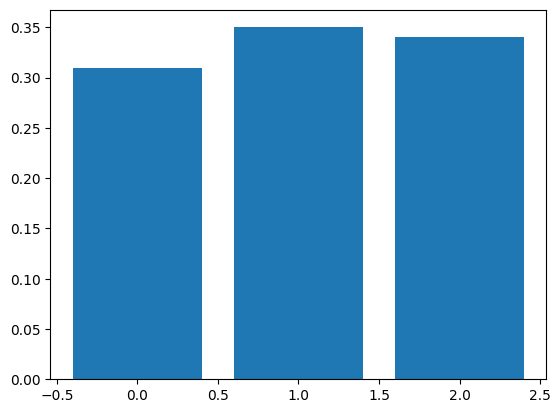

In [13]:
model_1=NBGaussian()
model_1.fit(X_train, y_train)
model_1.plot_pdf()

Nhận xét chart:
- Các histogram có dạng hình chuông, đối xứng qua trục tung, và có đỉnh tại giá trị trung bình của dữ liệu.
- Các histogram có độ rộng khác nhau, phản ánh sự khác biệt về độ biến thiên của dữ liệu giữa các lớp.
- Các histogram có đỉnh cao hơn ở các lớp 0 và 1, phản ánh sự phân bố dữ liệu tập trung hơn ở các lớp này.

#### Test

Label of X_test[10]:  2
Our histogram after update X_test[10]: 


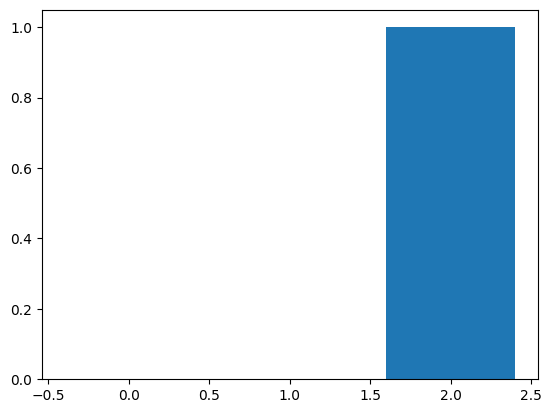

2

In [14]:
#label of y_test[10]
print('Label of X_test[10]: ', y_test[10])
#update model and show histogram with X_test[10]:

print('Our histogram after update X_test[10]: ')
model_1._predict(X_test[10],plot=True)


#### Đánh giá hiệu suất mô hình Gaussian Naive Bayes

In [15]:
pred=model_1.predict(X_test)
print('Accuracy of your Gaussian Naive Bayes model:', accuracy_score(y_test,pred))

Accuracy of your Gaussian Naive Bayes model: 0.96


## 2.3 Một số câu hỏi lí thuyết

*Đây là câu hỏi về lý thuyết có thể giúp các bạn buổi sung kiến thức cho các buổi phỏng vấn. Các bạn có thể tham khảo bất kì nguồn nào trừ ChatGPT và có thể thêm hình ảnh minh họa để có câu trả lời rõ ràng và dễ hiểu nhất. Và khi đã tham khảo phải liệt kê tài liệu tham khảo? Trường hợp phát hiện đạo văn bài làm sẽ nhận 0 điểm ngay lập tức.*

##### 1. Trường hợp sử dụng Gaussian Naive Bayes? Nêu chí tiết và cho 3 ứng dụng cụ thể (nêu rõ: input là gì? output là gì? mục tiêu sử dụng?)?

Câu trả lời:

Gaussian Naive Bayes là một phiên bản của thuật toán Naive Bayes, nó được sử dụng khi các thuộc tính (features) đầu vào là **liên tục** và được giả định tuân theo phân phối Gaussian (phân phối chuẩn).

**Chi tiết về cách hoạt động:**

*   **Giả định:** Các thuộc tính là độc lập với nhau khi cho một lớp (class) cụ thể. Điều này thường là một giả định "ngây thơ" (naive), nhưng thường hoạt động tốt trong thực tế.
*   **Phân phối Gaussian:** Với mỗi thuộc tính và mỗi lớp, Gaussian Naive Bayes ước tính các tham số của phân phối Gaussian:
    *   **Trung bình (mean):** Trung bình của các giá trị thuộc tính trong lớp đó.
    *   **Phương sai (variance):** Phương sai của các giá trị thuộc tính trong lớp đó.
*   **Tính xác suất:** Khi có một mẫu mới, thuật toán sẽ tính xác suất mẫu đó thuộc về mỗi lớp dựa trên phân phối Gaussian của từng thuộc tính và áp dụng định lý Bayes để tính xác suất hậu nghiệm (posterior probability).
*   **Phân loại:** Mẫu sẽ được gán cho lớp có xác suất hậu nghiệm cao nhất.

**3 Ứng dụng cụ thể:**

| Ứng dụng | Input | Output | Mục tiêu sử dụng |
| -------- | ----- | ------ | ---------------- |
| **1. Phân loại email spam/không spam** | Các đặc trưng của email (ví dụ: độ dài email, số từ, tần suất các từ nhất định) | Nhãn phân loại: "spam" hoặc "không spam" | Phân loại email tự động, lọc email rác, bảo vệ hộp thư người dùng. |
| **2. Phân loại bệnh dựa trên kết quả xét nghiệm** | Kết quả các xét nghiệm máu (ví dụ: nồng độ đường, cholesterol, tế bào máu)   | Nhãn phân loại: bệnh (hoặc không bệnh) hoặc các loại bệnh cụ thể  | Hỗ trợ bác sĩ trong việc chẩn đoán bệnh, phân loại bệnh nhân, hỗ trợ quyết định điều trị                               |
| **3. Phân loại người dùng dựa trên hoạt động web**| Các hành vi của người dùng trên web (ví dụ: thời gian truy cập, trang đã xem, sản phẩm đã mua)| Nhãn phân loại: Các nhóm người dùng (ví dụ: khách hàng tiềm năng, khách hàng trung thành) | Phân loại người dùng, cá nhân hóa trải nghiệm, gợi ý sản phẩm phù hợp, nhắm mục tiêu quảng cáo, cải thiện dịch vụ. |


##### 2. Có điều kiện bắt buộc nào của dữ liệu đầu vào khi sử dụng Gaussian Naive Bayes không?

Câu trả lời:

Có một số điều kiện quan trọng về dữ liệu đầu vào khi sử dụng Gaussian Naive Bayes:

1.  **Thuộc tính liên tục:** Dữ liệu đầu vào phải là các thuộc tính liên tục (ví dụ: chiều cao, cân nặng, nhiệt độ, giá trị xét nghiệm). Gaussian Naive Bayes không phù hợp với thuộc tính rời rạc (ví dụ: màu sắc, giới tính). Nếu dữ liệu có thuộc tính rời rạc, nên cân nhắc các biến thể khác của Naive Bayes như Multinomial Naive Bayes hoặc Bernoulli Naive Bayes.
2.  **Phân phối Gaussian (phân phối chuẩn):** Thuật toán giả định rằng mỗi thuộc tính (feature) theo một phân phối Gaussian trong mỗi lớp. Nếu thuộc tính không tuân theo phân phối này (hoặc phân phối khác biệt quá nhiều), hiệu suất có thể giảm. Tuy nhiên, trong thực tế, thuật toán vẫn hoạt động tốt ngay cả khi giả định này không hoàn toàn đúng.
3.  **Tính độc lập:** Gaussian Naive Bayes giả định rằng các thuộc tính là độc lập với nhau khi cho một lớp cụ thể. Đây là một giả định "ngây thơ" và thường không đúng trong thực tế. Tuy nhiên, thuật toán thường vẫn mang lại kết quả khá tốt ngay cả khi giả định này bị vi phạm.
4.  **Không có giá trị thiếu:** Gaussian Naive Bayes hoạt động tốt nhất khi dữ liệu không có giá trị thiếu (NaN). Cần xử lý giá trị thiếu trước khi sử dụng thuật toán (ví dụ: thay thế bằng giá trị trung bình hoặc loại bỏ mẫu).
5. **Dữ liệu số:** Dữ liệu đầu vào phải là dữ liệu số, không được có dữ liệu dạng chữ.

##### 3. Tại sao Naive Bayes thường được sử dụng trong các bài toán phân loại văn bản (Text Classification)?
Câu trả lời :

Naive Bayes là một thuật toán phân loại văn bản thường được sử dụng trong các bài toán phân loại văn bản (Text Classification) vì:

1.  **Nhanh và đơn giản:** Naive Bayes là một thuật toán đơn giản và dễ cài đặt. Nó có tốc độ huấn luyện nhanh chóng, đặc biệt là với dữ liệu lớn.
2.  **Hiệu quả với dữ liệu nhiều chiều:** Các bài toán phân loại văn bản thường có số lượng thuộc tính (từ vựng) rất lớn. Mặc dù có giả định hạn chế về tính độc lập, Naive Bayes vẫn hoạt động tốt với dữ liệu nhiều chiều như vậy.
3.  **Xử lý tốt dữ liệu rời rạc:** Các từ trong văn bản là các thuộc tính rời rạc (dạng "túi từ - bag of words", hoặc TF-IDF), và Multinomial Naive Bayes là một biến thể của Naive Bayes được thiết kế đặc biệt để xử lý các thuộc tính rời rạc dạng này.
4.  **Hoạt động tốt với ít dữ liệu:** Naive Bayes có thể hoạt động tốt ngay cả khi lượng dữ liệu huấn luyện không quá lớn, nhờ giả định độc lập của nó.

**Tuy nhiên:**

*   Giả định về tính độc lập là một hạn chế lớn của Naive Bayes. Các từ trong văn bản thường không độc lập với nhau (ví dụ, các cụm từ hoặc các từ có liên quan ngữ nghĩa). Tuy nhiên, dù có hạn chế này, Naive Bayes vẫn cho kết quả tốt trong nhiều trường hợp thực tế.
*   Cần tiền xử lý dữ liệu văn bản (ví dụ: loại bỏ stop words, stem/lemmatize từ) để có kết quả tốt nhất.

##### Tài liệu tham khảo:
*   Scikit-learn documentation. (n.d.). *sklearn.naive_bayes.GaussianNB*. Retrieved from [https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

## Tài liệu tham khảo

*   Géron, A. (2019). *Hands-on machine learning with Scikit-Learn, Keras & TensorFlow: Concepts, tools, and techniques to build intelligent systems*. O'Reilly Media.
*   Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The elements of statistical learning: data mining, inference, and prediction*. Springer Science & Business Media.
*   Scikit-learn documentation. (n.d.). *sklearn.naive_bayes.GaussianNB*. Retrieved from [https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
*   w3schools. (n.d.). *Python Machine Learning - Decision Tree*. Retrieved from [https://www.w3schools.com/python/python_ml_decision_tree.asp](https://www.w3schools.com/python/python_ml_decision_tree.asp)